# Telecom Churn Case Study

<!-- 
The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.
 -->

## Loading Libraries :-

In [1]:
# Pandas and Numpy
import pandas as pd
import numpy as np
import datetime as dt
import os
import re

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import pandas.plotting
from pandas.plotting import andrews_curves

# Satistics
from scipy.stats import zscore
from scipy.stats import norm, boxcox
from scipy import stats

# Modeling: Prerequisites
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
#from yellowbrick.model_selection import FeatureImportances

# Models
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB     
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest 
                                                                     
from sklearn.ensemble import RandomForestClassifier                 
from sklearn.ensemble import GradientBoostingClassifier             
from sklearn.ensemble import StackingClassifier                    
from sklearn.ensemble import VotingClassifier                      
from sklearn.ensemble import BaggingClassifier                       
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve                  
from sklearn.metrics import classification_report                   
from sklearn.metrics import plot_confusion_matrix      
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Declare user defined functions to be used for the model building :-

In [2]:
# Function to identify missing data
def missing_data(data):
    total = data.isna().sum()[data.isna().sum() != 0]
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing_df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_df = missing_df.sort_values('Total',ascending=False)
    if [missing_df['Total'] == 0]:
        missing_df.dropna(axis=0, inplace = True)
    return missing_df

In [3]:
# Function to drop columns based on thereshold of missing values
def drop_missing_value_col(x,thershold):
    drop_cols = (x.isnull().sum()/len(x))
    drop_cols = list(drop_cols[drop_cols.values >= thershold].index)
    print("No of cols to be dropped :",len(drop_cols))    
    print(drop_cols)
    x.drop(labels = drop_cols,axis =1, inplace = True)     
    print(x.shape)
    return

In [4]:
# Function to check unique values in a column.
def col_unique_value_check(x):
    single_value_col = [c for c in x.columns
                      if x[c].nunique()==1]
    print("Number of unique values are : ", x[single_value_col].nunique(), '\n')
    print("No of cols to be dropped :",len(single_value_col))
    print("Value Counts", '\n', x[single_value_col].value_counts(),'\n')
    x.drop(labels = single_value_col,axis =1, inplace = True)     
    print("Shape of data set after dropping single value col",x.shape)
    return 

In [5]:
# Function to impute/fill the null values.
def impute_values(x):
    missing_cols = [c for c in
                  x.columns
                  if x[c].isnull().sum()>0]
    int_col = [i for i in missing_cols
             if x[i].dtype == 'float64']
    str_col = [i for i in missing_cols
             if x[i].dtype == 'object' ]   
    print("Numeric Col",int_col)
    print('/n')
    print("Object Cols",str_col)
    for c in x.columns:
        if x[c].isnull().sum()>0:
            if x[c].dtype == 'float64':
                x[c].fillna(x[c].median(), inplace=True)
            elif x[c].dtype == 'int':
                x[c].fillna(x[c].median(), inplace=True)
            elif x[c].dtype == 'object':
                x[c].fillna(x[c].mode()[0], inplace=True)

In [6]:
# Function to enable ploting of confusion matrix of both test and train data 
# side by side for better visibility

def plot_c_matrix(model, title,X_train,X_test):
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, figsize=(20,7))
    plot_confusion_matrix(estimator = model, X = X_train, y_true = y_train, values_format = '.7g', cmap = 'YlGnBu', ax = ax1)
    plot_confusion_matrix(estimator = model, X = X_test, y_true = y_test, values_format = '.7g', cmap = 'YlGnBu', ax = ax2)
    
    ax1.set_title(label = 'Train Data', size = 14, color='blue', fontweight='bold')
    ax2.set_title(label = 'Test Data', size = 14, color='blue', fontweight='bold')
    
    ax1.set_ylabel('Actual', size = 14, color='green', fontweight='bold')
    ax2.set_ylabel('Actual', size = 14, color='green', fontweight='bold')
    
    ax1.tick_params(axis="x", labelsize=14, labelcolor="purple", width='bold')
    ax1.tick_params(axis="y", labelsize=14, labelcolor="purple", width='bold')
    ax2.tick_params(axis="x", labelsize=14, labelcolor="purple", width='bold')
    ax2.tick_params(axis="y", labelsize=14, labelcolor="purple", width='bold')
    
    ax1.set_xlabel('Predicted', size = 14, color='green', fontweight='bold')
    ax2.set_xlabel('Predicted', size = 14, color='green', fontweight='bold')
   
    ax1.grid(b = False)
    ax2.grid(b = False)
    plt.suptitle(t = 'Confusion Matrix :'+ title, size = 16,color='red', fontweight='bold' )
    plt.show()
    return()

In [7]:
#Function to enable printing all relevent scores and classifiaction report for both test and train data

def cal_scores(y_test, y_test_pred,y_train, y_train_pred, model):
    print('\nAccuracy Test,  ' + model +  ': {:.4f}'.format(accuracy_score(y_test, y_test_pred)))
    print('Accuracy Train, ' + model +  ': {:.4f}\n'.format(accuracy_score(y_train, y_train_pred)))
    
    print('\nTest Data Set')
    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_test_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_test_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_test_pred, average='micro')))
    
    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_test_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_test_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_test_pred, average='macro')))
    
    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_test_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_test_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_test_pred, average='weighted')))
    
    print('\nTrain Data Set')
    print('Micro Precision: {:.2f}'.format(precision_score(y_train, y_train_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_train, y_train_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_train, y_train_pred, average='micro')))
    
    print('Macro Precision: {:.2f}'.format(precision_score(y_train, y_train_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_train, y_train_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_train, y_train_pred, average='macro')))
    
    print('Weighted Precision: {:.2f}'.format(precision_score(y_train, y_train_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_train, y_train_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_train, y_train_pred, average='weighted')))
    
    print('\nClassification Report\n')
    print('                    Training Report          ')
    print(classification_report(y_train, y_train_pred))
    print('                    Testing Report           ')
    print(classification_report(y_test, y_test_pred))
    return()

In [8]:
# Classify function will run classification algorithms as given in the "clf_list" and return a dtaframe with accuracy score 
# of test and train data set in each algorithm
# It will do the .fit, > predict and append scores to a pre defiend list (test_Scores, train_scores)
# Then it returns a data frame, datafram has been declared global

def classify(clf_list,X_train,y_train,X_test,y_test):
    for clf in clf_list:
        clf.fit(X_train, y_train)
        clf.predict(X_train)
        clf.predict(X_test)
    
        clf.score(X_train, y_train)
        clf.score(X_test, y_test)
        
        train_scores.append(np.round(clf.score(X_train, y_train), decimals=2))
        test_scores.append(np.round(clf.score(X_test, y_test), decimals=2))
        clf_names.append(clf.__class__.__name__)
        
        # Decalred the accuracy_frame as global variable so as to enable further use of the data frame beyond the function
        global accuracy_frame 
        
        accuracy_frame = pd.DataFrame(data={'Train Accuracy': train_scores, 'Test Accuracy': test_scores},index=clf_names)

    return accuracy_frame

## Reading and Viewing the Dataset :-

In [9]:
# Reading the csv dataset.
train=pd.read_csv('train (1).csv')
train.shape

(69999, 172)

In [10]:
# Takinga look at the dataset for the first initial rows
train.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

In [11]:
# Checking the column information for the dataset
train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [12]:
# Check dataset column desciption
train.describe()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count  69999.000000    69999.0         69297.0         69297.0   
mean   34999.000000      109.0             0.0             0.0   
std    20207.115084        0.0             0.0             0.0   
min        0.000000      109.0             0.0             0.0   
25%    17499.500000      109.0             0.0             0.0   
50%    34999.000000      109.0             0.0             0.0   
75%    52498.500000      109.0             0.0             0.0   
max    69998.000000      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8   onnet_mou_6  \
count         69297.0  69999.000000  69999.000000  69999.000000  67231.000000   
mean              0.0    283.134365    278.185912    278.858826    133.153275   
std               0.0    334.213918    344.366927    351.924315    299.963093   
min               0.0  -2258.709000  -1289.715000   -945.808000      0.000000   
25%               0.0     93.581000     86.714000     84.095000      7.410000   
50%               0.0    197.484000    191.588000    192.234000     34.110000   
75%               0.0    370.791000    365.369500    369.909000    119.390000   
max               0.0  27731.088000  35145.834000  33543.624000   7376.710000   

        onnet_mou_7  ...   sachet_3g_7   sachet_3g_8     fb_user_6  \
count  67312.000000  ...  69999.000000  69999.000000  17568.000000   
mean     133.894438  ...      0.081444      0.085487      0.916325   
std      311.277193  ...      0.634547      0.680035      0.276907   
min        0.000000  ...      0.000000      0.000000      0.000000   
25%        6.675000  ...      0.000000      0.000000      1.000000   
50%       32.280000  ...      0.000000      0.000000      1.000000   
75%      115.837500  ...      0.000000      0.000000      1.000000   
max     8157.780000  ...     33.000000     41.000000      1.000000   

          fb_user_7     fb_user_8           aon    aug_vbc_3g    jul_vbc_3g  \
count  17865.000000  18417.000000  69999.000000  69999.000000  69999.000000   
mean       0.909544      0.890319   1220.639709     68.108597     65.935830   
std        0.286842      0.312501    952.426321    269.328659    267.899034   
min        0.000000      0.000000    180.000000      0.000000      0.000000   
25%        1.000000      1.000000    468.000000      0.000000      0.000000   
50%        1.000000      1.000000    868.000000      0.000000      0.000000   
75%        1.000000      1.000000   1813.000000      0.000000      0.000000   
max        1.000000      1.000000   4337.000000  12916.220000   9165.600000   

        jun_vbc_3g  churn_probability  
count  69999.00000       69999.000000  
mean      60.07674           0.101887  
std      257.22681           0.302502  
min        0.00000           0.000000  
25%        0.00000           0.000000  
50%        0.00000           0.000000  
75%        0.00000           0.000000  
max    11166.21000           1.000000  

[8 rows x 163 columns]

In [13]:
# Here we filtering out variable names based on the combinations of acrynoms using REGEX. 
# So, if I want the total minutes a person has spent on outgoing calls, 
# I need acronyms, TOTAL, OG and MOU. So corresponding regex is total.+og.+mou

ids = ['id','circle_id']
total_amounts = [i for i in list(train.columns) if re.search('total.+amt',i)]
total_outgoing_minutes = [i for i in list(train.columns) if re.search('total.+og.+mou',i)]
offnetwork_minutes = [i for i in list(train.columns) if re.search('offnet',i)]
average_revenue_3g = [i for i in list(train.columns) if re.search('arpu.+3g',i)]
average_revenue_2g = [i for i in list(train.columns) if re.search('arpu.+2g',i)]
volume_3g = [i for i in list(train.columns) if re.search('vol.+3g',i)]
volume_2g = [i for i in list(train.columns) if re.search('vol.+2g',i)]
age_on_network = [i for i in list(train.columns) if re.search('aon',i)]

#Storing them in a single flat list
variables = [*ids, 
             *total_amounts, 
             *total_outgoing_minutes, 
             *offnetwork_minutes, 
             *average_revenue_3g, 
             *average_revenue_2g,
             *volume_3g,
             *volume_2g,
             *age_on_network, 
             'churn_probability']

train = train[variables].set_index('id')

In [14]:
#  Re-Viewing the dataset
train.head()

circle_id  total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  \
id                                                                    
0         109                77                65                10   
1         109                 0               145                50   
2         109                70               120                 0   
3         109               160               240               130   
4         109               290               136               122   

    total_og_mou_6  total_og_mou_7  total_og_mou_8  offnet_mou_6  \
id                                                                 
0            81.21          221.68            3.63         32.24   
1             0.00           30.73           31.66          0.00   
2            56.49           99.36            0.00         53.99   
3            76.03           95.98           53.84         68.76   
4            63.26           42.94           15.76         56.99   

    offnet_mou_7  offnet_mou_8  ...  arpu_2g_7  arpu_2g_8  vol_3g_mb_6  \
id                              ...                                      
0          96.68          2.33  ...        NaN        NaN          0.0   
1          25.99         30.89  ...     122.08        NaN          0.0   
2          82.05          0.00  ...        NaN        NaN          0.0   
3          78.48         50.23  ...        NaN        NaN          0.0   
4          38.11          9.63  ...      35.12        0.0          0.0   

    vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  vol_2g_mb_7  vol_2g_mb_8   aon  \
id                                                                          
0          0.00          0.0          0.0         0.00         0.00  1958   
1          3.96          0.0          0.0       352.91         0.00   710   
2          0.00          0.0          0.0         0.00         0.00   882   
3          0.00          0.0          0.0         0.00         0.00   982   
4          0.00          0.0        390.8       308.89       213.47   647   

    churn_probability  
id                     
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 24 columns]

In [15]:
# Checkthe train dataset column information.
train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   circle_id          69999 non-null  int64  
 1   total_rech_amt_6   69999 non-null  int64  
 2   total_rech_amt_7   69999 non-null  int64  
 3   total_rech_amt_8   69999 non-null  int64  
 4   total_og_mou_6     69999 non-null  float64
 5   total_og_mou_7     69999 non-null  float64
 6   total_og_mou_8     69999 non-null  float64
 7   offnet_mou_6       67231 non-null  float64
 8   offnet_mou_7       67312 non-null  float64
 9   offnet_mou_8       66296 non-null  float64
 10  arpu_3g_6          17568 non-null  float64
 11  arpu_3g_7          17865 non-null  float64
 12  arpu_3g_8          18417 non-null  float64
 13  arpu_2g_6          17568 non-null  float64
 14  arpu_2g_7          17865 non-null  float64
 15  arpu_2g_8          18417 non-null  float64
 16  vol_3g_mb_6        699

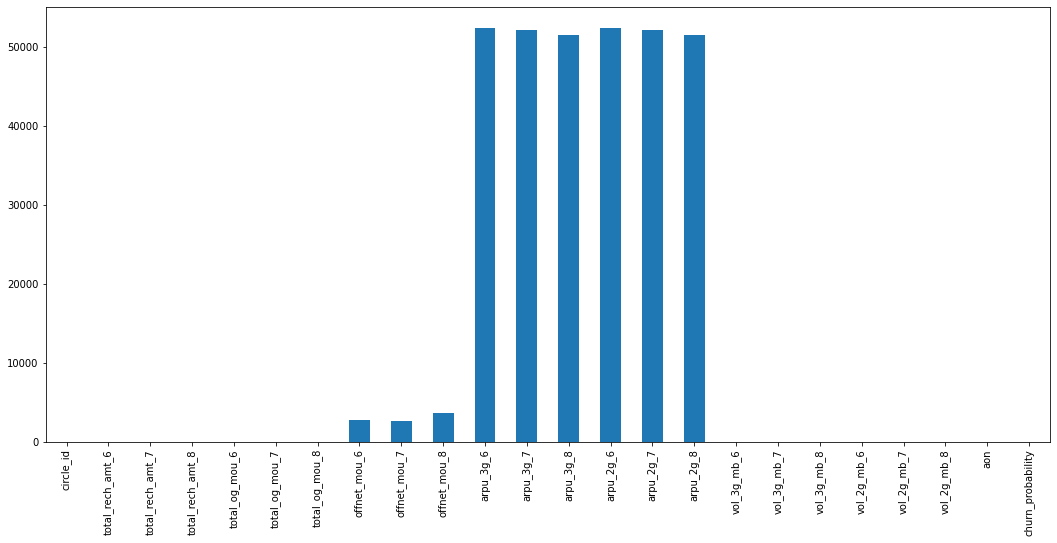

In [16]:
# visualize missing data
plt.figure(figsize=(18,8))
train.isnull().sum().plot.bar()
plt.show()

In [17]:
# Calculate and identify the  missing data percentage in columns.
missing_data_percent = 100*(train.isnull().sum()/len(train))
missing_data_percent

circle_id             0.000000
total_rech_amt_6      0.000000
total_rech_amt_7      0.000000
total_rech_amt_8      0.000000
total_og_mou_6        0.000000
total_og_mou_7        0.000000
total_og_mou_8        0.000000
offnet_mou_6          3.954342
offnet_mou_7          3.838626
offnet_mou_8          5.290076
arpu_3g_6            74.902499
arpu_3g_7            74.478207
arpu_3g_8            73.689624
arpu_2g_6            74.902499
arpu_2g_7            74.478207
arpu_2g_8            73.689624
vol_3g_mb_6           0.000000
vol_3g_mb_7           0.000000
vol_3g_mb_8           0.000000
vol_2g_mb_6           0.000000
vol_2g_mb_7           0.000000
vol_2g_mb_8           0.000000
aon                   0.000000
churn_probability     0.000000
dtype: float64

In [18]:
# Checking the missing value stats
missing_data(train)

Total    Percent
arpu_3g_6     52431.0  74.902499
arpu_2g_6     52431.0  74.902499
arpu_3g_7     52134.0  74.478207
arpu_2g_7     52134.0  74.478207
arpu_3g_8     51582.0  73.689624
arpu_2g_8     51582.0  73.689624
offnet_mou_8   3703.0   5.290076
offnet_mou_6   2768.0   3.954342
offnet_mou_7   2687.0   3.838626

In [19]:
# dropping the columns having missing values
drop_missing_value_col(train,.3)

No of cols to be dropped : 6
['arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']
(69999, 18)


In [20]:
# Checking column unique value
col_unique_value_check(train)

Number of unique values are :  circle_id    1
dtype: int64 

No of cols to be dropped : 1
Value Counts 
 circle_id
109          69999
dtype: int64 

Shape of data set after dropping single value col (69999, 17)


In [21]:
imputed_cols = impute_values(train)

Numeric Col ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
/n
Object Cols []


In [22]:
# Check for any remaining missing values.
missing_data(train)

# No missing values present.

Empty DataFrame
Columns: [Total, Percent]
Index: []

In [23]:
# Check  duplicates
duplicates = train[train.duplicated()]
duplicates.shape

(4, 17)

In [24]:
train.shape

(69999, 17)

In [25]:
train_1= train.copy()

In [26]:
train_1.shape

(69999, 17)

In [27]:
# Create X and y
X = train.drop(['churn_probability'],1).iloc[:,:-1]
y = train.iloc[:,-1]

X.shape, y.shape

((69999, 15), (69999,))

In [28]:
#  Do a terst train split of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 15), (14000, 15), (55999,), (14000,))

In [29]:
# Using standard scalar, we can use  min max scaler too.
std_scalar=StandardScaler()
num_train = X_train.select_dtypes(exclude=['<M8[ns]'])
num_train.columns
X_train[num_train.columns] = std_scalar.fit_transform(X_train[num_train.columns])

In [30]:
X_train.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
id                                                                            
48134         -0.185401         -0.051229         -0.170113       -0.657594   
1785           0.910601          0.935981          0.976761        1.474406   
13512         -0.533572         -0.007888         -0.467450       -0.275408   
3086           1.150887         -0.171621         -0.764788       -0.533092   
7409          -0.665975         -0.609846         -0.679834       -0.656992   

       total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                  
48134       -0.647868       -0.637568     -0.625424     -0.609452   
1785         2.508774        3.356250     -0.050343      1.568542   
13512       -0.067829       -0.300353     -0.114604      0.214251   
3086        -0.546985       -0.605040     -0.540202     -0.536126   
7409        -0.345574       -0.637568     -0.625424     -0.202187   

       offnet_mou_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  \
id                                                                        
48134     -0.602751     1.329818     0.718931     0.618071    -0.230661   
1785       3.535880    -0.220574    -0.229663    -0.237571    -0.241715   
13512     -0.130280    -0.220574    -0.229663    -0.237571    -0.241715   
3086      -0.558296     1.627273     1.213758    -0.237571    -0.216575   
7409      -0.602751    -0.220574    -0.229663    -0.237571    -0.241715   

       vol_2g_mb_7  vol_2g_mb_8  
id                               
48134    -0.181427    -0.220404  
1785     -0.241827    -0.233833  
13512    -0.241827    -0.233833  
3086     -0.175257    -0.233833  
7409     -0.241827    -0.233833

In [31]:
X_train.shape

(55999, 15)

In [32]:
# Create duymmies
str_train = X_train.select_dtypes(include=['<M8[ns]'])
str_train
X_train = pd.get_dummies(X_train, columns = (str_train.columns), drop_first = True)
X_train.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
id                                                                            
48134         -0.185401         -0.051229         -0.170113       -0.657594   
1785           0.910601          0.935981          0.976761        1.474406   
13512         -0.533572         -0.007888         -0.467450       -0.275408   
3086           1.150887         -0.171621         -0.764788       -0.533092   
7409          -0.665975         -0.609846         -0.679834       -0.656992   

       total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                  
48134       -0.647868       -0.637568     -0.625424     -0.609452   
1785         2.508774        3.356250     -0.050343      1.568542   
13512       -0.067829       -0.300353     -0.114604      0.214251   
3086        -0.546985       -0.605040     -0.540202     -0.536126   
7409        -0.345574       -0.637568     -0.625424     -0.202187   

       offnet_mou_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  \
id                                                                        
48134     -0.602751     1.329818     0.718931     0.618071    -0.230661   
1785       3.535880    -0.220574    -0.229663    -0.237571    -0.241715   
13512     -0.130280    -0.220574    -0.229663    -0.237571    -0.241715   
3086      -0.558296     1.627273     1.213758    -0.237571    -0.216575   
7409      -0.602751    -0.220574    -0.229663    -0.237571    -0.241715   

       vol_2g_mb_7  vol_2g_mb_8  
id                               
48134    -0.181427    -0.220404  
1785     -0.241827    -0.233833  
13512    -0.241827    -0.233833  
3086     -0.175257    -0.233833  
7409     -0.241827    -0.233833

## Exploratory Data Analysis :-

In [33]:
# Checking the missing data percentage in the dataset
missing_data_percent = 100*(X_train.isnull().sum()/len(X_train))
missing_data_percent

total_rech_amt_6    0.0
total_rech_amt_7    0.0
total_rech_amt_8    0.0
total_og_mou_6      0.0
total_og_mou_7      0.0
total_og_mou_8      0.0
offnet_mou_6        0.0
offnet_mou_7        0.0
offnet_mou_8        0.0
vol_3g_mb_6         0.0
vol_3g_mb_7         0.0
vol_3g_mb_8         0.0
vol_2g_mb_6         0.0
vol_2g_mb_7         0.0
vol_2g_mb_8         0.0
dtype: float64

In [34]:
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8'],
      dtype='object')

<AxesSubplot:>

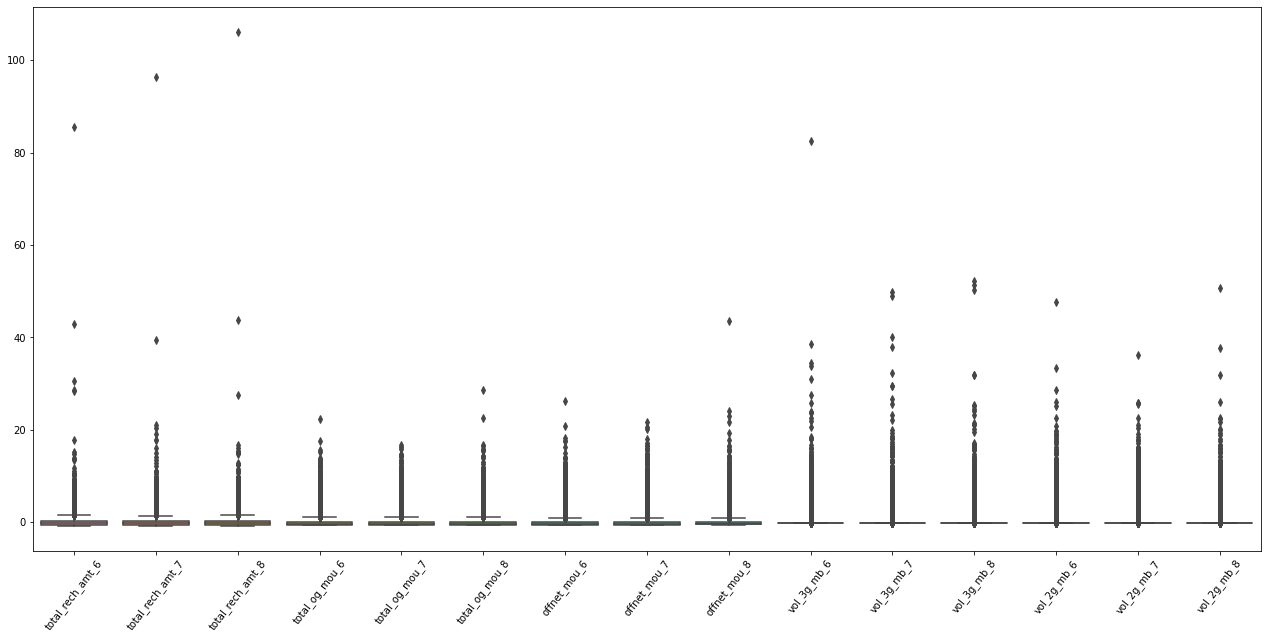

In [35]:
plt.figure(figsize=(22,10))
plt.xticks(rotation=52)
sns.boxplot(data = X_train)

### Handling the  Outliers :-

In [36]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

<AxesSubplot:>

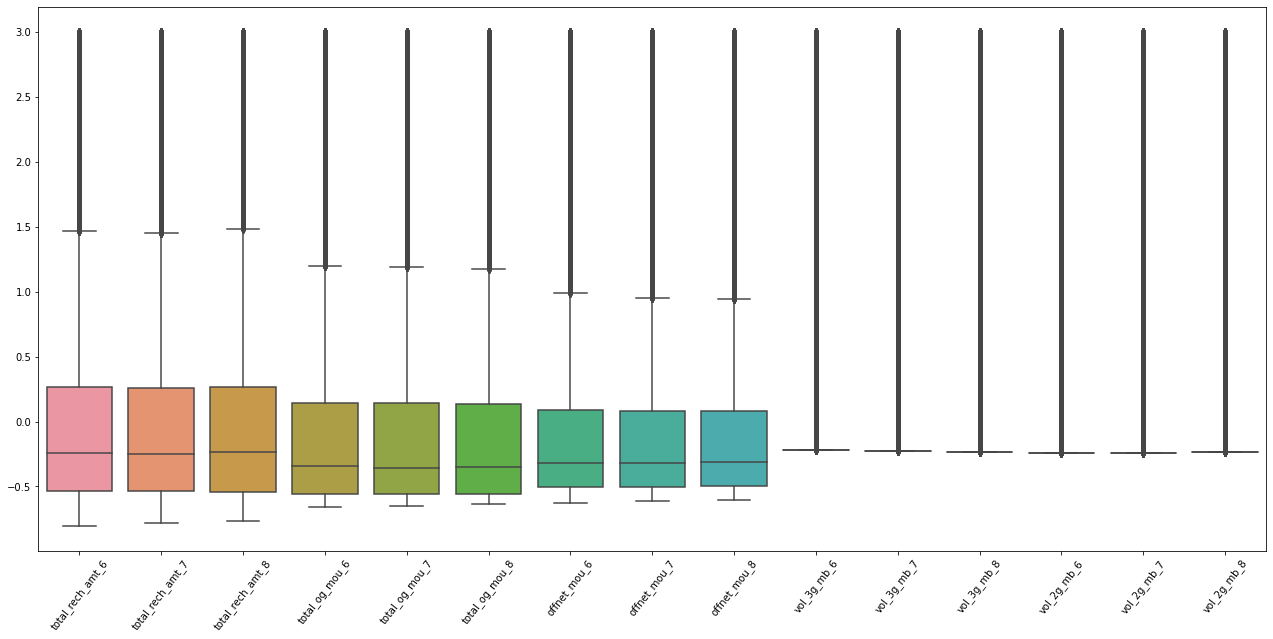

In [37]:
X_train = X_train.apply(cap_outliers, axis=0)

plt.figure(figsize=(22,10))
plt.xticks(rotation=52)
sns.boxplot(data = X_train)

### Checking Correlations :-

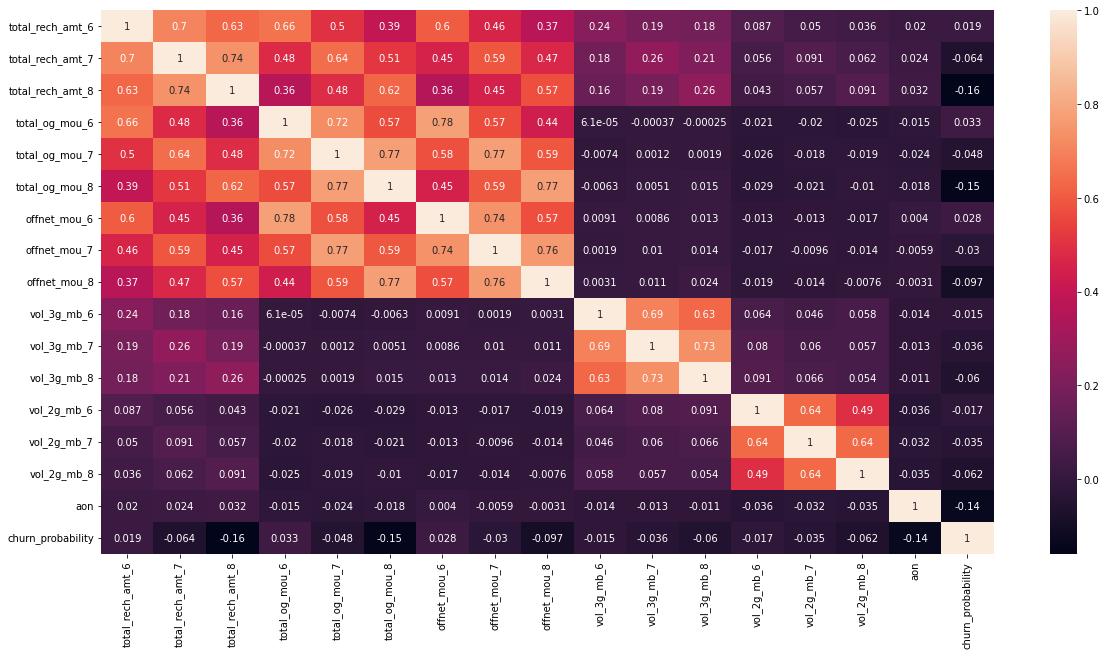

In [38]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(train.corr(),annot = True)
plt.show()

### Feature Scaling :-

In [39]:
scale = StandardScaler()
X_train_filtered = scale.fit_transform(X_train)

<AxesSubplot:>

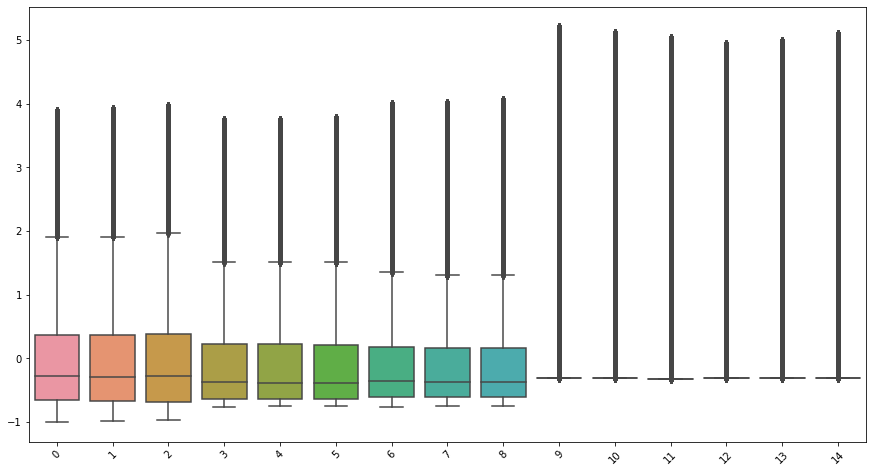

In [40]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered))

In [41]:
#  Using Principal component analysis.

from sklearn.decomposition import PCA

In [42]:
pca = PCA(0.95, random_state=0).fit(X_train)

In [43]:
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)

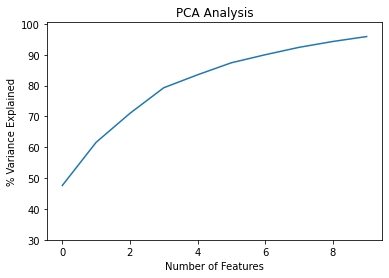

In [44]:
# View the feature variance.
plt.plot(var)
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(30, 100.5)
plt.style.context('seaborn-whitegrid')

In [45]:
# Printing the count of components leading to maximum variation in data.
print('%d components explain 95%% of the variation in data' % pca.n_components_)

10 components explain 95% of the variation in data


In [46]:
# Using Principal component analysis.
pca = PCA(n_components=11, random_state=0)
pca.fit(X_train)

X = pca.transform(X_train)
print(X.shape)

(55999, 11)


In [47]:
#  Creating the test train split
X_tr, X_te, y_tr, y_test = train_test_split(X, y_train, test_size=0.2, random_state=1)

In [48]:
# Initialize the Models

# Basic Classifier Algorithms
log_clf    = LogisticRegression(class_weight='balanced')
sv_clf     = SVC(class_weight='balanced', probability=True)
dt_clf     = DecisionTreeClassifier(class_weight='balanced')
knn_clf    = KNeighborsClassifier(n_neighbors=5)

#Bagging Algorithms
rf_clf     = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1)
bag_clf    = BaggingClassifier(base_estimator=dt_clf, n_estimators=500, n_jobs=-1)
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rf_clf), ('dt', dt_clf), ('svc', sv_clf)], voting='soft')

#Boosting Algorithms
ada_clf    = AdaBoostClassifier(base_estimator=dt_clf, n_estimators=500)
gb_clf     = GradientBoostingClassifier(n_estimators=500)

# Stacking Alogrithm
# Creating a collection of estimators
estimators = [('logistic', LogisticRegression(class_weight='balanced', n_jobs=-1)), 
              ('svc', SVC(class_weight='balanced', probability=True)),
              ('knn', KNeighborsClassifier(n_jobs=-1)),
              ('randomforest', RandomForestClassifier(class_weight='balanced', n_jobs=-1))]

# Setting StackingClassifier with initiated estimators and a final estimator
stack_clf = StackingClassifier(estimators=estimators, 
                               final_estimator=GradientBoostingClassifier(), 
                               n_jobs=-1, cv=5)

In [49]:
%%time

# Checking the test and train data accuracy for each model.
train_scores = []
test_scores  = []
clf_names    = []

#clf_list = [log_clf, sv_clf, dt_clf,rf_clf,knn_clf,voting_clf,ada_clf,gb_clf]
# Note- Calculating Accuracy for the mentioned  classifiers takes some time.
clf_list=[log_clf,dt_clf,rf_clf,bag_clf,voting_clf,ada_clf,gb_clf]
classify(clf_list,X_tr,y_tr,X_te,y_test)

CPU times: user 16min 36s, sys: 7.35 s, total: 16min 43s
Wall time: 15min 57s


Train Accuracy  Test Accuracy
LogisticRegression                    0.66           0.66
DecisionTreeClassifier                1.00           0.88
RandomForestClassifier                1.00           0.92
BaggingClassifier                     1.00           0.92
VotingClassifier                      0.99           0.91
AdaBoostClassifier                    1.00           0.92
GradientBoostingClassifier            0.93           0.92

<AxesSubplot:title={'center':'Accuracy Scores for Test and Train Data'}, xlabel='ML Models', ylabel='Accuracy Score'>

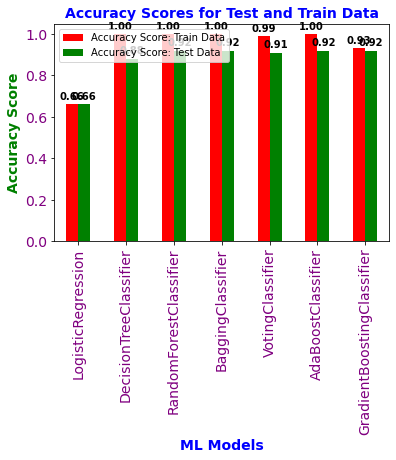

In [50]:
# Viewing the  test and train data accuracy for each model.
plots=accuracy_frame.plot(kind = "bar", color = "rgb")
plt.title('Accuracy Scores for Test and Train Data', color = 'blue', fontweight = 'bold', fontsize =14)
plt.xlabel('ML Models', color = 'blue', fontweight = 'bold', fontsize =14)
plt.ylabel('Accuracy Score', color = 'green', fontweight = 'bold', fontsize =14)
plt.tick_params(labelcolor='purple', labelsize=14)
plt.legend(labels=['Accuracy Score: Train Data','Accuracy Score: Test Data'],frameon =True,title_fontsize=14)
for bar in plots.patches:
    plt.annotate(format(bar.get_height(), '.2f'), (bar.get_x() + bar.get_width() / 2, 
    bar.get_height()), ha='center', va='center',size=10,weight = "bold", xytext=(0, 8),
    textcoords='offset points')
plots

In [51]:
# Import Simple Imputer
from sklearn.impute import SimpleImputer

In [52]:
#  Impute and create the pipeline.
imp = SimpleImputer(strategy='constant', fill_value=0)


pipe = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',log_clf)])

In [53]:
#  Checking/Viewing the pipeline.
pipe.fit(X_train[new_vars], y_train)

Pipeline(steps=[('imputation',
                 SimpleImputer(fill_value=0, strategy='constant')),
                ('scaling', StandardScaler()),
                ('pca', PCA(n_components=11, random_state=0)),
                ('model', LogisticRegression(class_weight='balanced'))])

In [54]:
# Checking the model's accuracy rate on the train dataset. 
train_score = pipe.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

Training accuracy: 0.6564581510384114


In [55]:
# Reading the test dataset.
test=pd.read_csv('test (1).csv')
test.shape

(30000, 171)

In [56]:
# Viewing the initial rows for the test dataset.
test.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  69999        109             0.0             0.0             0.0   
1  70000        109             0.0             0.0             0.0   
2  70001        109             0.0             0.0             0.0   
3  70002        109             0.0             0.0             0.0   
4  70003        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   91.882   
1            6/30/2014            7/31/2014            8/31/2014  414.168   
2            6/30/2014            7/31/2014            8/31/2014  329.844   
3            6/30/2014            7/31/2014            8/31/2014   43.550   
4            6/30/2014            7/31/2014            8/31/2014  306.854   

    arpu_7  ...  sachet_3g_6  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  \
0   65.330  ...            0            0            0        NaN        NaN   
1  515.568  ...            0            0            0        NaN        NaN   
2  434.884  ...            0            0            0        NaN        NaN   
3  171.390  ...            0            0            0        NaN        NaN   
4  406.289  ...            0            0            0        NaN        NaN   

   fb_user_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  
0        NaN  1692        0.00        0.00        0.00  
1        NaN  2533        0.00        0.00        0.00  
2        NaN   277      525.61      758.41      241.84  
3        NaN  1244        0.00        0.00        0.00  
4        NaN   462        0.00        0.00        0.00  

[5 rows x 171 columns]

In [57]:
#  Checking the info of the columns from the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 171 entries, id to jun_vbc_3g
dtypes: float64(135), int64(27), object(9)
memory usage: 39.1+ MB


In [58]:
data = test.set_index('id')[new_vars]
data.shape

(30000, 15)

In [59]:
data.head()

total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  total_og_mou_6  \
id                                                                            
69999               103                90                60           91.94   
70000               500               500               500          549.86   
70001               500              1000              1000            0.00   
70002               110               260                 0           45.36   
70003               356               490               546          514.79   

       total_og_mou_7  total_og_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                  
69999           52.39           57.94         60.16         32.16   
70000          663.06          415.59        474.34        621.84   
70001            0.00            0.00         16.98         45.81   
70002          207.18           24.01         40.04        205.01   
70003          638.28          779.78         60.94         23.84   

       offnet_mou_8  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  vol_2g_mb_6  \
id                                                                        
69999         34.83          0.0          0.0          0.0          0.0   
70000        394.94          0.0          0.0          0.0          0.0   
70001         45.04          0.0          0.0          0.0          0.0   
70002         24.01          0.0          0.0          0.0          0.0   
70003         74.16          0.0          0.0          0.0          0.0   

       vol_2g_mb_7  vol_2g_mb_8  
id                               
69999          0.0          0.0  
70000          0.0          0.0  
70001          0.0          0.0  
70002          0.0          0.0  
70003          0.0          0.0

In [60]:
#  Checking the shape of the test dataset
data.shape

(30000, 15)

In [61]:
# Predict using the  model.
data['churn_probability'] = pipe.predict(data)

In [62]:
# Checking the output info, there should be 30000 columns mandatorily.
output = data[['churn_probability']]
output.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 69999 to 99998
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   churn_probability  30000 non-null  int64
dtypes: int64(1)
memory usage: 468.8 KB


In [63]:
data.reset_index(level=0, inplace=True)

In [64]:
# Viewing the output [id and churn probability] computed by the model.
output = data[['id','churn_probability']]
output

id  churn_probability
0      69999                  0
1      70000                  0
2      70001                  0
3      70002                  1
4      70003                  0
...      ...                ...
29995  99994                  0
29996  99995                  0
29997  99996                  0
29998  99997                  1
29999  99998                  0

[30000 rows x 2 columns]

In [65]:
# Saving the final output into a CSV file
output.to_csv('Telecom_churn_probability.csv',index=False)